<center><h1>Ye_Jinyi_Final_Project</h1></center>

Name: Jinyi Ye
<br>
Github Username: angelayejinyi
<br>
USC ID: 1552624974

## 1. Transfer Learning for Video Classification

Import packages

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import splitfolders
import cv2
import random
from PIL import Image

### (d) Data Exploration and Pre-processing

#### ii. Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.

In [ ]:
# On running the below code snippet, it will create 3 folders in the output directory: train, val, test
# The number of images in each folder can be varied using the values in the ratio argument(train:val:test).

splitfolders.ratio('../data/Sport Images', 
                   output="../data/Sport Images", seed=1337, ratio=(0.7, 0.15, 0.15)) 

#### iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

First, we convert all .gif files into .jpg files.

In [14]:
# Set the input and output folder paths
input_folder = "../data/Sport Images"
output_folder = "../data/Sport Images"

# Loop through all files in the input folder
sport_lst = ['baseball','basketball','fencing','tennis','volleyball']
for sport in sport_lst:
    for filename in os.listdir(os.path.join(input_folder, sport)):
        # Check if the file has a .gif extension
        if filename.endswith('.gif'):
            # Open the GIF image and convert the first frame to RGB format
            gif_image = Image.open(os.path.join(input_folder, sport, filename))
            first_frame = gif_image.convert('RGB')
            # Save the first frame as a JPEG image
            output_filename = os.path.splitext(filename)[0] + '.jpg'
            output_path = os.path.join(output_folder, sport, output_filename)
            first_frame.save(output_path)
            # Delete the original GIF image
            os.remove(os.path.join(input_folder, sport, filename))

Next, we resize all images using OpenCV. We also remove the embedded color profile from the image.

In [ ]:
# use the OpenCV library to resize images
input_dir = "../data/Sport Images"
output_dir = "../data/Sport Images/resized_images"
size = (500, 500)

# loop through all the files in the input directory
sport_lst = ['baseball','basketball','fencing','tennis','volleyball']
for sport in sport_lst:
    for filename in os.listdir(os.path.join(input_dir, sport)):
        input_path = os.path.join(input_dir, sport, filename)
        output_path = os.path.join(output_dir, sport, filename)  
        
        # Open the image file
        img = Image.open(input_path)
        # Check if the image has an embedded color profile
        if "icc_profile" in img.info:
            # Remove the embedded color profile
            del img.info["icc_profile"]
        # Save the image without the color profile
        img.save(input_path)
        
        try:
            # load the image from the input path
            image = cv2.imread(input_path)
            # resize the image to the desired size using bilinear interpolation
            resized_image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
            # save the resized image to the output path
            cv2.imwrite(output_path, resized_image)
        except:
            print('Could not read image', input_path)
            continue

Split the datasets into train, validation and test.

In [3]:
splitfolders.ratio('../data/Sport Images/resized_images', 
                   output="../data/Sport Images/resized_images", seed=1115, ratio=(0.7, 0.15, 0.15)) 

Copying files: 3280 files [00:32, 100.25 files/s]


### (e) Transfer Learning for Image Classification

#### ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation.

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

2023-05-05 17:06:55.550020: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 17:06:56.538611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 17:06:56.540009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 17:06:59.177151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load the data using a data loader or image generator
train_dir = '../data/Sport Images/resized_images/train'
val_dir = '../data/Sport Images/resized_images/val'

# Define image generators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 5

# Load the training and validation data using the image generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(500, 500),
    batch_size=batch_size,
    class_mode='categorical',
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(500, 500),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 2292 images belonging to 5 classes.
Found 490 images belonging to 5 classes.


In [4]:
train_data.class_indices

{'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

#### iv. Train the networks ResNet50, EfficientNetB0, and VGG16 for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

##### ResNet50

In [5]:
# Define the base model architecture
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(500, 500, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the ResNet50 model architecture with the last layer having ReLU activation and a softmax layer
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model using ADAM optimizer, multinomial cross entropy loss, and batch normalization with a dropout rate of 20%
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the fit() function with early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=50,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stopping],
    workers=-1)

Epoch 1/50


2023-05-04 15:06:05.949526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


458/458 [==============================] - ETA: 0s - loss: 1.6018 - accuracy: 0.3406

2023-05-04 15:08:58.752651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


458/458 [==============================] - 206s 444ms/step - loss: 1.6018 - accuracy: 0.3406 - val_loss: 19.6511 - val_accuracy: 0.1490
Epoch 2/50
458/458 [==============================] - 310s 677ms/step - loss: 1.4617 - accuracy: 0.3953 - val_loss: 1.6281 - val_accuracy: 0.3878
Epoch 3/50
458/458 [==============================] - 310s 677ms/step - loss: 1.4193 - accuracy: 0.4128 - val_loss: 1.8908 - val_accuracy: 0.3469
Epoch 4/50
458/458 [==============================] - 311s 678ms/step - loss: 1.3947 - accuracy: 0.4289 - val_loss: 1.7236 - val_accuracy: 0.4020
Epoch 5/50
458/458 [==============================] - 311s 679ms/step - loss: 1.3524 - accuracy: 0.4421 - val_loss: 6.0606 - val_accuracy: 0.2306
Epoch 6/50
458/458 [==============================] - 311s 680ms/step - loss: 1.3538 - accuracy: 0.4263 - val_loss: 1.3130 - val_accuracy: 0.5041
Epoch 7/50
458/458 [==============================] - 280s 611ms/step - loss: 1.3351 - accuracy: 0.4534 - val_loss: 1.7386 - val_accur

In [18]:
# load test data
test_dir = '../data/Sport Images/resized_images/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(500, 500),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 497 images belonging to 5 classes.


2023-05-04 16:03:35.628777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 24s 247ms/step - loss: 1.5125 - accuracy: 0.3980
Test accuracy: 0.3979797959327698


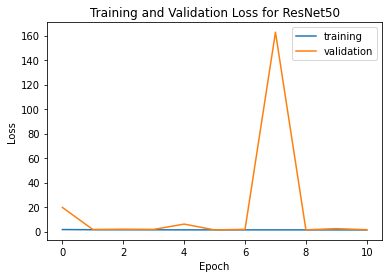

In [8]:
# Evaluate the model on the test set
test_steps = test_data.samples // test_data.batch_size
test_loss, test_acc = model.evaluate(test_data, steps=test_steps)
print('Test accuracy:', test_acc)

# Plot the training and validation errors vs. epochs
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# make predictions on training set
train_pred = model.predict(train_data)
train_pred_classes = np.argmax(train_pred, axis=1)
train_true_classes = train_data.classes

# make predictions on test set
test_pred = model.predict(test_data)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_data.classes

# compute confusion matrix, precision, recall, accuracy, and F1 score for training set
train_cm = confusion_matrix(train_true_classes, train_pred_classes)
train_report = classification_report(train_true_classes, train_pred_classes)
train_accuracy = accuracy_score(train_true_classes, train_pred_classes)
train_f1_score = f1_score(train_true_classes, train_pred_classes, average='weighted')
train_precision = precision_score(train_true_classes, train_pred_classes, average='weighted')
train_recall = recall_score(train_true_classes, train_pred_classes, average='weighted')

# compute confusion matrix, precision, recall, accuracy, and F1 score for test set
test_cm = confusion_matrix(test_true_classes, test_pred_classes)
test_report = classification_report(test_true_classes, test_pred_classes)
test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
test_f1_score = f1_score(test_true_classes, test_pred_classes, average='weighted')
test_precision = precision_score(test_true_classes, test_pred_classes, average='weighted')
test_recall = recall_score(test_true_classes, test_pred_classes, average='weighted')

# print the results
print('Training set accuracy:', train_accuracy)
print('Training set F1 score:', train_f1_score)
print('Training set precision:', train_precision)
print('Training set recall:', train_recall)
print('Training set confusion matrix:\n', train_cm)
print('Training set classification report:\n', train_report)
print()
print('Test set accuracy:', test_accuracy)
print('Test set F1 score:', test_f1_score)
print('Test set precision:', test_precision)
print('Test set recall:', test_recall)
print('Test set confusion matrix:\n', test_cm)
print('Test set classification report:\n', test_report)

2023-05-04 16:40:23.758814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


459/459 [==============================] - 204s 445ms/step


2023-05-04 16:44:45.782997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 45s 446ms/step
Training set accuracy: 0.3957242582897033
Training set F1 score: 0.3317159288901385
Training set precision: 0.5915022939528076
Training set recall: 0.3957242582897033
Training set confusion matrix:
 [[423  72  11   2   5]
 [ 60 264  17   1   2]
 [220  88 126   8   1]
 [378  63  22  32   5]
 [218 204   4   4  62]]
Training set classification report:
               precision    recall  f1-score   support

           0       0.33      0.82      0.47       513
           1       0.38      0.77      0.51       344
           2       0.70      0.28      0.40       443
           3       0.68      0.06      0.12       500
           4       0.83      0.13      0.22       492

    accuracy                           0.40      2292
   macro avg       0.58      0.41      0.34      2292
weighted avg       0.59      0.40      0.33      2292


Test set accuracy: 0.3983903420523139
Test set F1 score: 0.3306771162601863
Test set precision: 0.55

In [9]:
model.save('../data/model/ResNet50.h5')

##### EfficientNetB0

In [7]:
# Resize to 224*224 pixels
train_data_EN = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

val_data_EN = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

# Define the base model architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the ResNet50 model architecture with the last layer having ReLU activation and a softmax layer
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model using ADAM optimizer, multinomial cross entropy loss, and batch normalization with a dropout rate of 20%
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the fit() function with early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_data_EN,
    steps_per_epoch=train_data_EN.samples // train_data_EN.batch_size,
    epochs=50,
    validation_data=val_data_EN,
    validation_steps=val_data_EN.samples // val_data_EN.batch_size,
    callbacks=[early_stopping],
    workers=-1)

Found 2292 images belonging to 5 classes.
Found 490 images belonging to 5 classes.
Epoch 1/50


2023-05-04 22:01:47.677740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


458/458 [==============================] - ETA: 0s - loss: 1.7703 - accuracy: 0.2256

2023-05-04 22:02:23.243072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


458/458 [==============================] - 42s 81ms/step - loss: 1.7703 - accuracy: 0.2256 - val_loss: 2.0384 - val_accuracy: 0.2286
Epoch 2/50
458/458 [==============================] - 35s 77ms/step - loss: 1.6759 - accuracy: 0.2396 - val_loss: 1.9582 - val_accuracy: 0.1939
Epoch 3/50
458/458 [==============================] - 35s 77ms/step - loss: 1.6607 - accuracy: 0.2134 - val_loss: 2.4739 - val_accuracy: 0.1939
Epoch 4/50
458/458 [==============================] - 36s 78ms/step - loss: 1.6403 - accuracy: 0.2379 - val_loss: 1.8094 - val_accuracy: 0.2143
Epoch 5/50
458/458 [==============================] - 34s 75ms/step - loss: 1.6470 - accuracy: 0.2383 - val_loss: 1.5729 - val_accuracy: 0.2286
Epoch 6/50
458/458 [==============================] - 36s 77ms/step - loss: 1.6283 - accuracy: 0.2361 - val_loss: 1.8090 - val_accuracy: 0.2163
Epoch 7/50
458/458 [==============================] - 35s 76ms/step - loss: 1.6154 - accuracy: 0.2401 - val_loss: 1.5986 - val_accuracy: 0.2367
Epo

In [8]:
# load test data
test_dir = '../data/Sport Images/resized_images/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_EN = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 497 images belonging to 5 classes.


 3/99 [..............................] - ETA: 4s - loss: 1.2053 - accuracy: 0.0000e+00

2023-05-04 22:14:57.382526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 5s 48ms/step - loss: 1.5739 - accuracy: 0.2909
Test accuracy: 0.290909081697464


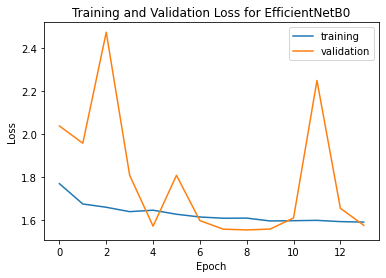

In [11]:
# Evaluate the model on the test set
test_steps = test_data_EN.samples // test_data_EN.batch_size
test_loss, test_acc = model.evaluate(test_data_EN, steps=test_steps)
print('Test accuracy:', test_acc)

# Plot the training and validation errors vs. epochs
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for EfficientNetB0')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# make predictions on training set
train_pred = model.predict(train_data_EN)
train_pred_classes = np.argmax(train_pred, axis=1)
train_true_classes = train_data.classes

# make predictions on test set
test_pred = model.predict(test_data_EN)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_data.classes

# compute confusion matrix, precision, recall, accuracy, and F1 score for training set
train_cm = confusion_matrix(train_true_classes, train_pred_classes)
train_report = classification_report(train_true_classes, train_pred_classes)
train_accuracy = accuracy_score(train_true_classes, train_pred_classes)
train_f1_score = f1_score(train_true_classes, train_pred_classes, average='weighted')
train_precision = precision_score(train_true_classes, train_pred_classes, average='weighted')
train_recall = recall_score(train_true_classes, train_pred_classes, average='weighted')

# compute confusion matrix, precision, recall, accuracy, and F1 score for test set
test_cm = confusion_matrix(test_true_classes, test_pred_classes)
test_report = classification_report(test_true_classes, test_pred_classes)
test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
test_f1_score = f1_score(test_true_classes, test_pred_classes, average='weighted')
test_precision = precision_score(test_true_classes, test_pred_classes, average='weighted')
test_recall = recall_score(test_true_classes, test_pred_classes, average='weighted')

# print the results
print('Training set accuracy:', train_accuracy)
print('Training set F1 score:', train_f1_score)
print('Training set precision:', train_precision)
print('Training set recall:', train_recall)
print('Training set confusion matrix:\n', train_cm)
print('Training set classification report:\n', train_report)
print()
print('Test set accuracy:', test_accuracy)
print('Test set F1 score:', test_f1_score)
print('Test set precision:', test_precision)
print('Test set recall:', test_recall)
print('Test set confusion matrix:\n', test_cm)
print('Test set classification report:\n', test_report)

  2/459 [..............................] - ETA: 27s 

2023-05-04 22:15:22.768059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  2/100 [..............................] - ETA: 5s

2023-05-04 22:15:50.224691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 5s 48ms/step
Training set accuracy: 0.21771378708551484
Training set F1 score: 0.12149960433518563
Training set precision: 0.13361490676113835
Training set recall: 0.21771378708551484
Training set confusion matrix:
 [[ 36   0   0 428  49]
 [ 22   0   0 294  28]
 [ 38   0   0 368  37]
 [ 32   0   0 430  38]
 [ 44   0   0 415  33]]
Training set classification report:
               precision    recall  f1-score   support

           0       0.21      0.07      0.11       513
           1       0.00      0.00      0.00       344
           2       0.00      0.00      0.00       443
           3       0.22      0.86      0.35       500
           4       0.18      0.07      0.10       492

    accuracy                           0.22      2292
   macro avg       0.12      0.20      0.11      2292
weighted avg       0.13      0.22      0.12      2292


Test set accuracy: 0.2917505030181087
Test set F1 score: 0.1962111987748659
Test set precision: 0.

/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/si

In [ ]:
model.save('../data/model/EfficientNetB0.h5')

##### VGG16

In [4]:
# Define the base model architecture
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the ResNet50 model architecture with the last layer having ReLU activation and a softmax layer
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model using ADAM optimizer, multinomial cross entropy loss, and batch normalization with a dropout rate of 20%
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the fit() function with early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=50,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stopping],
    workers=-1)

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/50


2023-05-04 15:12:41.789037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


458/458 [==============================] - ETA: 0s - loss: 1.3111 - accuracy: 0.5448

2023-05-04 15:16:25.691728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


458/458 [==============================] - 269s 585ms/step - loss: 1.3111 - accuracy: 0.5448 - val_loss: 2.9345 - val_accuracy: 0.4878
Epoch 2/50
458/458 [==============================] - 268s 586ms/step - loss: 0.9524 - accuracy: 0.6410 - val_loss: 0.6942 - val_accuracy: 0.7816
Epoch 3/50
458/458 [==============================] - 265s 578ms/step - loss: 0.8512 - accuracy: 0.6913 - val_loss: 0.8187 - val_accuracy: 0.7469
Epoch 4/50
458/458 [==============================] - 268s 585ms/step - loss: 0.8344 - accuracy: 0.6948 - val_loss: 17.9293 - val_accuracy: 0.1490
Epoch 5/50
458/458 [==============================] - 265s 579ms/step - loss: 0.7823 - accuracy: 0.7171 - val_loss: 0.7152 - val_accuracy: 0.7776
Epoch 6/50
458/458 [==============================] - 267s 582ms/step - loss: 0.7456 - accuracy: 0.7280 - val_loss: 0.6372 - val_accuracy: 0.7918
Epoch 7/50
458/458 [==============================] - 266s 581ms/step - loss: 0.7196 - accuracy: 0.7464 - val_loss: 0.6278 - val_accur

In [9]:
# load test data
test_dir = '../data/Sport Images/resized_images/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(500, 500),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 497 images belonging to 5 classes.


2023-05-04 16:37:40.165458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 45s 456ms/step - loss: 0.5030 - accuracy: 0.8323
Test accuracy: 0.8323232531547546


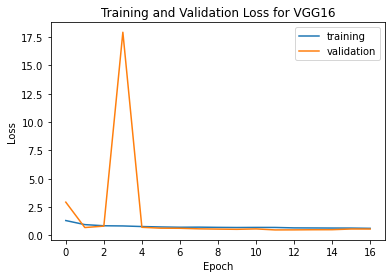

In [10]:
# Evaluate the model on the test set
test_steps = test_data.samples // test_data.batch_size
test_loss, test_acc = model.evaluate(test_data, steps=test_steps)
print('Test accuracy:', test_acc)

# Plot the training and validation errors vs. epochs
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG16')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# make predictions on training set
train_pred = model.predict(train_data)
train_pred_classes = np.argmax(train_pred, axis=1)
train_true_classes = train_data.classes

# make predictions on test set
test_pred = model.predict(test_data)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_data.classes

# compute confusion matrix, precision, recall, accuracy, and F1 score for training set
train_cm = confusion_matrix(train_true_classes, train_pred_classes)
train_report = classification_report(train_true_classes, train_pred_classes)
train_accuracy = accuracy_score(train_true_classes, train_pred_classes)
train_f1_score = f1_score(train_true_classes, train_pred_classes, average='weighted')
train_precision = precision_score(train_true_classes, train_pred_classes, average='weighted')
train_recall = recall_score(train_true_classes, train_pred_classes, average='weighted')

# compute confusion matrix, precision, recall, accuracy, and F1 score for test set
test_cm = confusion_matrix(test_true_classes, test_pred_classes)
test_report = classification_report(test_true_classes, test_pred_classes)
test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
test_f1_score = f1_score(test_true_classes, test_pred_classes, average='weighted')
test_precision = precision_score(test_true_classes, test_pred_classes, average='weighted')
test_recall = recall_score(test_true_classes, test_pred_classes, average='weighted')

# print the results
print('Training set accuracy:', train_accuracy)
print('Training set F1 score:', train_f1_score)
print('Training set precision:', train_precision)
print('Training set recall:', train_recall)
print('Training set confusion matrix:\n', train_cm)
print('Training set classification report:\n', train_report)
print()
print('Test set accuracy:', test_accuracy)
print('Test set F1 score:', test_f1_score)
print('Test set precision:', test_precision)
print('Test set recall:', test_recall)
print('Test set confusion matrix:\n', test_cm)
print('Test set classification report:\n', test_report)

2023-05-04 16:39:38.795622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


459/459 [==============================] - 210s 458ms/step


2023-05-04 16:43:09.423402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 45s 454ms/step
Training set accuracy: 0.8512216404886562
Training set F1 score: 0.8497335371608542
Training set precision: 0.8615645253934701
Training set recall: 0.8512216404886562
Training set confusion matrix:
 [[437   0  16  52   8]
 [ 26 224  25  46  23]
 [ 13   1 399  17  13]
 [ 17   2  14 464   3]
 [ 14   4  20  27 427]]
Training set classification report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86       513
           1       0.97      0.65      0.78       344
           2       0.84      0.90      0.87       443
           3       0.77      0.93      0.84       500
           4       0.90      0.87      0.88       492

    accuracy                           0.85      2292
   macro avg       0.87      0.84      0.85      2292
weighted avg       0.86      0.85      0.85      2292


Test set accuracy: 0.8329979879275654
Test set F1 score: 0.8324212560708912
Test set precision: 0.84

In [ ]:
model.save('../data/model/VGG16.h5')

Thus, in this task, VGG16 performs better than ResNet and EfficientNet, yielding a test accuracy of about 0.83. ResNet50 follows with an test set accuracy of 0.40.

Unfortunately, after resizing images to the recommended size of 224x224, EfficientNetB0 still failed to yield reasonable results, with performance similar to random classifier. It's possible that the poor performance of EfficientNetB0 is not solely due to data normalization or model architecture, but could also be related to the specific task or data distribution.

### (f) Video Classification Using Moving Averages

#### i. In order to have a better deep learner, reuse the validation and test data and train the network, without seriously overfitting it.

Start fresh, train with both training data and validation data up to the previous number of epochs.

In [4]:
# Combine the training and validation data
combined_dir = '../data/Sport Images/resized_images/train+val'

combined_data = train_datagen.flow_from_directory(
    combined_dir,
    target_size=(500, 500),
    batch_size=batch_size,
    class_mode='categorical',
)

# load test data as validation set
test_dir = '../data/Sport Images/resized_images/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(500, 500),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 2782 images belonging to 5 classes.
Found 497 images belonging to 5 classes.


##### ResNet50

In [7]:
# Define the base model architecture
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(500, 500, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the ResNet50 model architecture with the last layer having ReLU activation and a softmax layer
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model using ADAM optimizer, multinomial cross entropy loss, and batch normalization with a dropout rate of 20%
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the fit() function with previous number of epochs
history = model.fit(
    combined_data,
    steps_per_epoch=combined_data.samples // combined_data.batch_size,
    validation_data=test_data,
    validation_steps=test_data.samples // test_data.batch_size,
    epochs=11,
    workers=-1)

Epoch 1/11


2023-05-04 19:56:29.431483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


556/556 [==============================] - ETA: 0s - loss: 1.6149 - accuracy: 0.3533

2023-05-04 20:01:18.200322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


556/556 [==============================] - 337s 601ms/step - loss: 1.6149 - accuracy: 0.3533 - val_loss: 60.8574 - val_accuracy: 0.2182
Epoch 2/11
556/556 [==============================] - 385s 692ms/step - loss: 1.4262 - accuracy: 0.4055 - val_loss: 1.5589 - val_accuracy: 0.4101
Epoch 3/11
556/556 [==============================] - 386s 694ms/step - loss: 1.3871 - accuracy: 0.4166 - val_loss: 1.5772 - val_accuracy: 0.4101
Epoch 4/11
556/556 [==============================] - 380s 684ms/step - loss: 1.3590 - accuracy: 0.4328 - val_loss: 1.3589 - val_accuracy: 0.4202
Epoch 5/11
556/556 [==============================] - 388s 698ms/step - loss: 1.3537 - accuracy: 0.4415 - val_loss: 1.4184 - val_accuracy: 0.4606
Epoch 6/11
556/556 [==============================] - 379s 682ms/step - loss: 1.3564 - accuracy: 0.4462 - val_loss: 2.6340 - val_accuracy: 0.2222
Epoch 7/11
556/556 [==============================] - 412s 741ms/step - loss: 1.3225 - accuracy: 0.4613 - val_loss: 1.6295 - val_accur

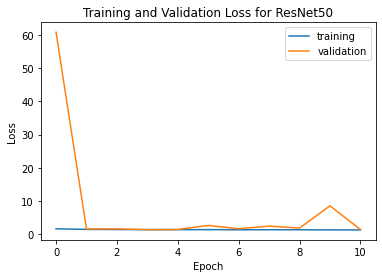

In [9]:
# Plot the training and validation errors vs. epochs
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50')
plt.legend()
plt.show()

In [ ]:
# save the new model
model.save('../data/model/ResNet50_new.h5')

##### EfficientNetB0

In [15]:
# Combine the training and validation data
combined_dir = '../data/Sport Images/resized_images/train+val'

combined_data_EN = train_datagen.flow_from_directory(
    combined_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

# load test data as validation set
test_dir = '../data/Sport Images/resized_images/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_EN = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

# Define the base model architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the ResNet50 model architecture with the last layer having ReLU activation and a softmax layer
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model using ADAM optimizer, multinomial cross entropy loss, and batch normalization with a dropout rate of 20%
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the fit() function with previous number of epochs
history = model.fit(
    combined_data_EN,
    steps_per_epoch=combined_data_EN.samples // combined_data_EN.batch_size,
    validation_data=test_data_EN,
    validation_steps=test_data_EN.samples // test_data_EN.batch_size,
    epochs=14,
    workers=-1)

Found 2782 images belonging to 5 classes.
Found 497 images belonging to 5 classes.
Epoch 1/14


2023-05-04 22:18:31.474563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


556/556 [==============================] - ETA: 0s - loss: 1.7370 - accuracy: 0.2269

2023-05-04 22:19:14.427064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


556/556 [==============================] - 49s 79ms/step - loss: 1.7370 - accuracy: 0.2269 - val_loss: 3.5063 - val_accuracy: 0.1515
Epoch 2/14
556/556 [==============================] - 42s 75ms/step - loss: 1.6788 - accuracy: 0.2132 - val_loss: 1.8607 - val_accuracy: 0.1515
Epoch 3/14
556/556 [==============================] - 42s 76ms/step - loss: 1.6455 - accuracy: 0.2319 - val_loss: 1.8493 - val_accuracy: 0.2162
Epoch 4/14
556/556 [==============================] - 42s 75ms/step - loss: 1.6265 - accuracy: 0.2294 - val_loss: 1.5774 - val_accuracy: 0.2444
Epoch 5/14
556/556 [==============================] - 43s 78ms/step - loss: 1.6288 - accuracy: 0.2362 - val_loss: 1.6429 - val_accuracy: 0.2081
Epoch 6/14
556/556 [==============================] - 42s 75ms/step - loss: 1.6131 - accuracy: 0.2550 - val_loss: 1.6519 - val_accuracy: 0.2202
Epoch 7/14
556/556 [==============================] - 43s 78ms/step - loss: 1.6181 - accuracy: 0.2272 - val_loss: 1.5641 - val_accuracy: 0.2485
Epo

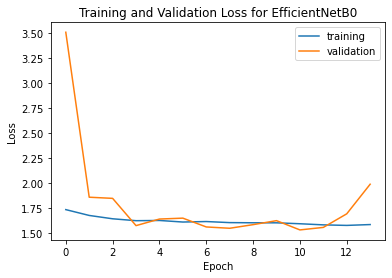

In [16]:
# Plot the training and validation errors vs. epochs
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for EfficientNetB0')
plt.legend()
plt.show()

In [ ]:
# save the new model
model.save('../data/model/EfficientNetB0_new.h5')

##### VGG16

In [11]:
# Define the base model architecture
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the ResNet50 model architecture with the last layer having ReLU activation and a softmax layer
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model using ADAM optimizer, multinomial cross entropy loss, and batch normalization with a dropout rate of 20%
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the fit() function with previous number of epochs
history = model.fit(
    combined_data,
    steps_per_epoch=combined_data.samples // combined_data.batch_size,
    validation_data=test_data,
    validation_steps=test_data.samples // test_data.batch_size,
    epochs=17,
    workers=-1)

Epoch 1/17


2023-05-04 19:58:21.401022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


556/556 [==============================] - ETA: 0s - loss: 1.2695 - accuracy: 0.5448

2023-05-04 20:02:53.831701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


556/556 [==============================] - 318s 570ms/step - loss: 1.2695 - accuracy: 0.5448 - val_loss: 0.7969 - val_accuracy: 0.7010
Epoch 2/17
556/556 [==============================] - 317s 571ms/step - loss: 0.9163 - accuracy: 0.6687 - val_loss: 0.7574 - val_accuracy: 0.7111
Epoch 3/17
556/556 [==============================] - 309s 556ms/step - loss: 0.8472 - accuracy: 0.6975 - val_loss: 0.5631 - val_accuracy: 0.7879
Epoch 4/17
556/556 [==============================] - 315s 566ms/step - loss: 0.8010 - accuracy: 0.7054 - val_loss: 0.5312 - val_accuracy: 0.8061
Epoch 5/17
556/556 [==============================] - 315s 566ms/step - loss: 0.7958 - accuracy: 0.7040 - val_loss: 0.8166 - val_accuracy: 0.7253
Epoch 6/17
556/556 [==============================] - 315s 566ms/step - loss: 0.7518 - accuracy: 0.7288 - val_loss: 0.4841 - val_accuracy: 0.8222
Epoch 7/17
556/556 [==============================] - 318s 572ms/step - loss: 0.7221 - accuracy: 0.7461 - val_loss: 0.4571 - val_accura

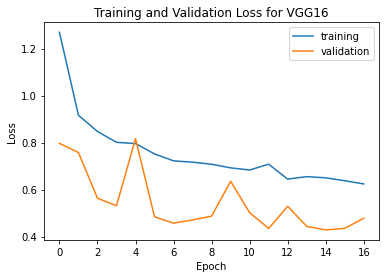

In [12]:
# Plot the training and validation errors vs. epochs
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG16')
plt.legend()
plt.show()

In [ ]:
# save the new model
model.save('../data/model/VGG16_new.h5')

After reusing the validation and test data, all three models showed an improvement in performance.

#### ii. Apply at least L equally spaced frames of each video in the folder Sport Videos5 to your model to obtain L vectors of probability predictions from the softmax in your model. You must choose L to be at least 100, but you are welcome to use all the frames in each video. Calculate the average p ̄ of these probability vectors for each video.

#### iii. Select the class with maximum probability in the vector p ̄ for each video and compare it to the actual label of the video.

#### iv. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for your model on the test data, i.e. videos. Remember that this is a multi-class classification problem.

In [27]:
from tensorflow.keras.models import load_model

def video_classification(model):
    # Load the saved model
    saved_model = load_model(os.path.join('../data/model/' + model + '.h5'))

    # Define the video folder
    video_folder = '../data/Sport Videos'

    # Define the input size of the model
    input_size = (500, 500)

    # Define the class names
    sports_lst = ['BaseballPitch','Basketball','Fencing','TennisSwing','VolleyballSpiking']
    pred_class_lst = []
    actual_class_lst = []

    # Loop over all the videos in the folder
    for sport in sports_lst:
        for video_file in os.listdir(os.path.join(video_folder, sport)):
            # Read the video file
            cap = cv2.VideoCapture(os.path.join(video_folder, sport, video_file))

            # Calculate the total number of frames and the frame interval
            num_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Initialize the probability vector
            prob_vector = np.zeros((len(sports_lst),))

            # Loop over the frames
            for i in range(num_frames_total):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i) # Set the video position to the current frame index
                ret, frame = cap.read() # Read the frame and resize it to the input size
                if not ret:
                    break
                frame = cv2.resize(frame, input_size)

                # Preprocess the frame and pass it through the model to obtain the probability predictions
                frame = frame.astype('float32') / 255.0
                frame = np.expand_dims(frame, axis=0)
                prob = saved_model.predict(frame, verbose=0)[0]

                # Add the probability predictions to the probability vector
                prob_vector += prob

            # Average the probability vector
            prob_vector /= num_frames_total

            # Select the class with the maximum probability and compare it to the actual label
            pred_class = np.argmax(prob_vector)
            actual_class = sports_lst.index(sport)
            pred_class_lst.append(pred_class)
            actual_class_lst.append(actual_class)
     
    return pred_class_lst, actual_class_lst

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(pred_class_lst, actual_class_lst):
    # compute confusion matrix, precision, recall, accuracy, and F1 score for test set
    test_cm = confusion_matrix(actual_class_lst, pred_class_lst)
    test_report = classification_report(actual_class_lst, pred_class_lst)
    test_accuracy = accuracy_score(actual_class_lst, pred_class_lst)
    test_f1_score = f1_score(actual_class_lst, pred_class_lst, average='weighted', zero_division=0)
    test_precision = precision_score(actual_class_lst, pred_class_lst, average='weighted', zero_division=0)
    test_recall = recall_score(actual_class_lst, pred_class_lst, average='weighted', zero_division=0)

    # print the results
    print('Test set accuracy:', test_accuracy)
    print('Test set F1 score:', test_f1_score)
    print('Test set precision:', test_precision)
    print('Test set recall:', test_recall)
    print('Test set confusion matrix:\n', test_cm)
    print('Test set classification report:\n', test_report)

In [3]:
actual_class_lst = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                   3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
                   4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

##### ResNet50

In [ ]:
pred_class_lst, actual_class_lst = video_classification('ResNet50_new')

In [16]:
evaluate_model(pred_class_lst, actual_class_lst)

Test set accuracy: 0.18208516886930984
Test set F1 score: 0.09210922339412461
Test set precision: 0.2798780979567529
Test set recall: 0.18208516886930984
Test set confusion matrix:
 [[  1   0  30   0 119]
 [  0   0  69   0  68]
 [  0   0  46   0  65]
 [  0   0  93   0  74]
 [  0   0  39   0  77]]
Test set classification report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       150
           1       0.00      0.00      0.00       137
           2       0.17      0.41      0.24       111
           3       0.00      0.00      0.00       167
           4       0.19      0.66      0.30       116

    accuracy                           0.18       681
   macro avg       0.27      0.22      0.11       681
weighted avg       0.28      0.18      0.09       681



/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### EfficientNetB0

In [ ]:
pred_class_lst, actual_class_lst = video_classification('EfficientNetB0_new')

In [18]:
evaluate_model(pred_class_lst, actual_class_lst)

Test set accuracy: 0.25844346549192365
Test set F1 score: 0.1599979165283946
Test set precision: 0.28448818902425915
Test set recall: 0.25844346549192365
Test set confusion matrix:
 [[  0   0  24 126   0]
 [  0   0  12 125   0]
 [  0   0  30  81   0]
 [  0   0  26 141   0]
 [ 49   0   9  53   5]]
Test set classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.00      0.00      0.00       137
           2       0.30      0.27      0.28       111
           3       0.27      0.84      0.41       167
           4       1.00      0.04      0.08       116

    accuracy                           0.26       681
   macro avg       0.31      0.23      0.15       681
weighted avg       0.28      0.26      0.16       681



/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### VGG16

In [ ]:
pred_class_lst, actual_class_lst = video_classification('VGG16_new')

In [14]:
evaluate_model(pred_class_lst, actual_class_lst)

Test set accuracy: 0.527165932452276
Test set F1 score: 0.45517071772424
Test set precision: 0.4104098588284369
Test set recall: 0.527165932452276
Test set confusion matrix:
 [[135   0   2  12   1]
 [ 29   0  31  63  14]
 [  8   0  90   0  13]
 [ 14   0  28 100  25]
 [ 26   0  33  23  34]]
Test set classification report:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75       150
           1       0.00      0.00      0.00       137
           2       0.49      0.81      0.61       111
           3       0.51      0.60      0.55       167
           4       0.39      0.29      0.33       116

    accuracy                           0.53       681
   macro avg       0.40      0.52      0.45       681
weighted avg       0.41      0.53      0.46       681



/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/jinyiy/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the results, we can observe that VGG16 achieved the highest classification accuracy of 53%. However, none of the classifiers were able to correctly classify any samples to the basketball class. It is possible that the features used to train the classifiers may not be discriminative enough to distinguish basketball from other sports. Further analysis of the data and the classifiers may help identify the reasons behind the poor performance on the basketball class, such as insufficient or biased data, or limitations in the chosen models.